# Natural Computing, assignment 3 - task 2

Group 8 - Guus, Bono, Charlotte

## Libraries

In [227]:
import subprocess
import os
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter #Use of container datatype, https://docs.python.org/3/library/collections.html

# Task 2

In [228]:
# current directory
print(os.getcwd())

syscalls_folder = 'syscalls'
results_folder = 'Task2'
subfolders = ['snd-cert', 'snd-unm']
test_files_indexes = ['1', '2', '3']

/Users/charlottecvn/Downloads/Natural Computing/negative-selection


In [229]:
# load data 
def load_train(input_file, output_file, chunk_size=7):
    result = []
    with open(input_file) as df:
        for line in df:
            result.append(line.rstrip())

    train_seq = set()
    for i in result:
        substrings = []
        for j in range(len(i)-chunk_size+1):
            substrings.append(i[j:j+chunk_size])
        train_seq.update(substrings)
    
    with open(output_file, 'w') as df:
        for s in train_seq:
            df.write(s + "\n")

def load_labels(input_file):
    out = []
    with open (input_file) as df:
        for i in df:
            out.append(int(i.rstrip()))
    return out
            
process_seq(f"{syscalls_folder}/{subfolders[0]}/{subfolders[0]}.train",
            f"{results_folder}/{subfolders[0]}.train")
process_seq(f"{syscalls_folder}/{subfolders[1]}/{subfolders[1]}.train",
            f"{results_folder}/{subfolders[1]}.train")

In [230]:
# functions to be able to analyse according to chunk_size
def unique_substrings(test_file, chunk_size):
    c = []
    with open(test_file) as df:
        for sequence in df:
            c.append(unique_counter(sequence.rstrip(), chunk_size))
    return c

def unique_counter(s, chunk_size):
    c = Counter()
    for i in range(len(s)-chunk_size+1):
        ss = s[i:i + chunk_size]
        c[ss] += 1
    return c

In [231]:
# java outputs (terminal, subprocess) for composite anomaly score (classification)
def terminal_output_chunks(train_file, alpha_file, test_unique, n, r):
    command_java = f"java -jar negsel2.jar -alphabet file://{alpha_file} -self {train_file} -n {n} -r {r} -c -l"
    stream = subprocess.Popen([command_java], shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    scores_results = []
    
    for sub in test_unique:
        scores = []
        for sequence_i in sub.keys():
            stream.stdin.write(sequence_i.encode('utf-8'))
            stream.stdin.write(b'\n')
            stream.stdin.flush()
            output = stream.stdout.readline()
            score = float(output.rstrip()) * sub[sequence_i]
            scores.append(score)
        scores_results.append(sum(scores)/sum(sub.values()))
    
    return scores_results

In [232]:
# functions to calculate the sensitivity and specificity
def sensitivity (distinct, positive_lbls):
    sensitivity_distinct = []
    for i, score in enumerate(distinct):
        positive = distinct[i:]
        true_pos = len([score for score in positive if score[1] == 1])
        sensitivity_distinct.append(true_pos / positive_lbls)
    return sensitivity_distinct

def specificity (distinct, negative_lbls):
    specificity_distinct = []
    for i, score in enumerate(distinct):
        negative = distinct[:i]
        true_neg = len([score for score in negative if score[1] == 0])
        specificity_distinct.append(1 - true_neg / negative_lbls)
    return specificity_distinct

In [233]:
# auc output (score and plots) for the desired files
def auc_output (test_file, train_file, alphabet_file, labels, n_values, r_values, title, title_num):
    fig = plt.figure()

    for n in n_values: 
        test_unique = unique_substrings(test_file, n)
        for r in r_values:
            results_anomaly = terminal_output_chunks(train_file, alphabet_file, test_unique, n, r)
            anomaly_labels = tuple(zip(results_anomaly, labels))
            sorted_distinct = sorted(anomaly_labels, key=lambda tup: tup[0])
            
            positive_lbls = len([x for x in labels if x == 1])
            negative_lbls = len([x for x in labels if x == 0])
            
            sensitivity_auc = sensitivity(sorted_distinct, positive_lbls) 
            specificity_auc = specificity(sorted_distinct, negative_lbls)
           
            auc_roc_score = metrics.auc(specificity_auc, sensitivity_auc)
            #auc_roc_score = metrics.roc_auc_score(labels, results_anomaly)
            
            plt.plot(specificity_auc, sensitivity_auc, label=f"n={n}, r={r}; AUC: {np.round(auc_roc_score,3)}")
            
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('sensitivity')
    plt.ylabel('1-specificity') 
    plt.legend()
    plt.title(f"ROC-curve, {title}.{title_num}")

    fig.savefig('{}/task2_ROC_{}_{}.png'.format(os.path.join(os.getcwd(), results_folder), title, title_num))

    plt.show()

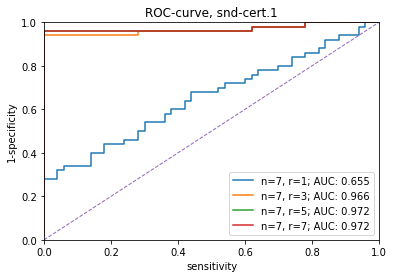

In [ ]:
n_values = [7] #chunk_size
r_values = [1,3,5,7]

for i in range(len(subfolders)):
    for j in range(len(test_files_indexes)):
        train_file = f"{results_folder}/{subfolders[i]}.train"
        test_file = f"{syscalls_folder}/{subfolders[i]}/{subfolders[i]}.{test_files_indexes[j]}.test"
        labels = load_labels(f"{syscalls_folder}/{subfolders[i]}/{subfolders[i]}.{test_files_indexes[j]}.labels")
        alpha_file = f"{syscalls_folder}/{subfolders[i]}/{subfolders[i]}.alpha"
        auc_output(test_file, train_file, alpha_file, labels, n_values, r_values, subfolders[i], test_files_indexes[j])